## Programming Exercise 3: Multi-class Classification and Neural Networks
#### Author - Rishabh Jain

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
%matplotlib inline

from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;Multi-class Classification

##### Problem Statement
For this exercise, we will use **logistic regression** and **neural networks** to recognize handwritten digits (from 0 to 9). In this part of the exercise we will extend our previous implementation of logistic regression and apply it to one-vs-all classification.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Dataset
We are given a dataset in ex3data.mat that contains 5000 training examples of handwritten digits, where each training example is a 20 X 20 pixel grayscale image of the digit. Each pixel is repsented by a floating point number indicating the grayscale intensity at that location.  

This 20 by 20 pixel grid is "unrolled" into 400-dimensional vector. Each of these training examples become a single row in our dataset. This gives us a 5000 X 400 design matrix X where every row is a training example for a handwritten digit image. The second part of the training set is a 5000-dimnesional vectory y that contains labels for the training set. Labels range from 1 to 10 where 10 reprsents digit '0'.

In [2]:
# Loading Mat file
mat=loadmat('./ex3data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'].T[i]

# Converting label 10 to label 0
mat['y'][mat['y']==10]=0    
data['y']=mat['y']

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the data
We will begin by visualizing a subset of the training set. We will randomly select 100 rows from X. This function maps each row to a 20 X 20 pixel image and displays together.

In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray)
    plt.axis('off')

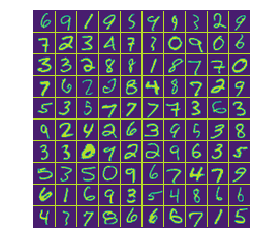

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Vectorizing Logistic Regression
We will be using mutiple one-vs-all logistic regression models to build multi-class classifier. Since there are 10 classes, we wil need to train 10 separate logistic regression. To make this training efficient, it is important to ensure that our code is well vectorized. In this section, we will implement a vectorized version of logistic regression that does not employ any for loops.

**Formulae :**

$$ h_\theta(x)=g(\theta^Tx) $$
$$ g(z)=\frac{1}{1+e^{-z}} $$
$$ J(\theta)= \frac{-1}{m}\sum_{i=0}^m[y^{(i)}log(h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)})]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$
$$ \theta_j:=\theta_j-\frac{\alpha}{m}(\sum_{i=0}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}+\lambda\sum_{j=1}^n\theta_j) $$

**From the previous notebook(Exercise-2), all the functions are already vectorized.**

In [6]:
def sigmoid(z):
    sigma=1/(1+np.exp(-z))
    return sigma

In [7]:
def predict(X,theta):
    '''Predicts by applying logistic function on linear model'''
    z=np.dot(X,theta.T)
    h=sigmoid(z)
    return h

In [8]:
def computeCost(h,y):
    '''Computes the cost using Cross Entropy function'''
    m=y.shape[0]
    J=(-1/m)*np.sum(np.multiply(y,np.log(h))+np.multiply(1-y,np.log(1-h)))
    return J

In [9]:
def regularizedGradientDescent(X,y,theta,alpha,lmbda,iterations):
    '''Minimizes the cost function using Gradient Descent Optimization Algorithm'''
    m=X.shape[0]
    jHistory=[]
    for i in range(iterations):
        h=predict(X,theta)
        # Computing cost
        J=computeCost(h,y)
        # Adding the regularized term
        J=J+(lmbda/(2*m))*np.sum(np.power(theta[:,1:],2))
        jHistory.append(J)
        # Parameters update rule
        gradient=(alpha/m)*(np.dot((h-y).T,X))
        # Adding the regularized term
        gradient=gradient+(alpha/m)*lmbda*np.sum(theta[:,1:])
        theta=theta-gradient
    return (theta,jHistory)

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;One-vs-all Classification
In this part of the exercise, **we will implement One-vs-all classification by training multiple logistic regression classifiers, one for each of K classes in our dataset.**

In [10]:
def oneVsAll(X,Y,alpha,lmbda,iterations):
    '''Returns all the classifier parameters in a matrix with shape of classes X features'''
    m,n=X.shape
    # Initializing theta
    intialTheta=np.zeros(shape=(1,n))
    labels=np.unique(Y)
    labels.sort()
    thetas=np.zeros(shape=(len(labels),n))
    i=0
    print('Training classifiers...\n')
    for label in labels:
        y=np.zeros(shape=(m,1))
        y[Y==label]=1
        theta,jHistory=regularizedGradientDescent(X,y,intialTheta,alpha,lmbda,iterations)
        thetas[i,:]=theta
        print(f'For classifier{label} , J = {jHistory[iterations-1]:.3f}')
        i+=1
    return thetas

In [11]:
m=data.shape[0]

X=data.values[:,:-1]
# Adding intercept term to the design matrix
intercept=np.ones(shape=(m,1))
X=np.column_stack((intercept,X))
y=data['y'].values.reshape((m,1))

alpha=1
lmbda=0.1
iterations=3000

thetas=oneVsAll(X,y,alpha,lmbda,iterations)

Training classifiers...

For classifier0 , J = 0.014
For classifier1 , J = 0.022
For classifier2 , J = 0.061
For classifier3 , J = 0.065
For classifier4 , J = 0.046
For classifier5 , J = 0.066
For classifier6 , J = 0.029
For classifier7 , J = 0.040
For classifier8 , J = 0.086
For classifier9 , J = 0.081


#### 1.4.1&nbsp;&nbsp;&nbsp;&nbsp;One-vs-all Prediction
After training One-vs-all classifier, we can use it to predict the digit contained in a given image. For each input, we should compute the 'probability' that it belongs to each class using the trained logistic regression classifiers.

In [12]:
def predictOneVsAll(thetas,X):
    '''Predic the label for a trained One-vs-all classifier. The labels are in the range 0 to 9'''
    h=predict(X,thetas)
    labels=h.argmax(axis=1)
    return labels.reshape((X.shape[0],1))

In [13]:
def calculateAccuracy(h,y):
    '''Calculates the accuray between the target and prediction'''
    m=y.shape[0]
    unique,counts=np.unique(h==y,return_counts=True)
    dic=dict(zip(unique,counts))
    accuracy=(dic[True]/m)*100
    return accuracy

In [14]:
h=predictOneVsAll(thetas,X)
accuracy=calculateAccuracy(h,y)
print(f'TRAINING ACCURACY : {accuracy:.2f}')

TRAINING ACCURACY : 94.18
